### Teixeira Scheme

Parameters optimized in two steps: 1) Manual optimization, 2) Nelder-Mead

--> I use the best set of parameters from the manually tuned code as a starting point

In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys
import os
import gc

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression')
from functions import append_dict_to_json
from sklearn import tree

subset_size = 10**8

np.random.seed(10)

**Read data**

In [2]:
all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_possible_features)):
    loc_all[all_possible_features[i]] = i
    
# Features
features = ['clw', 'cli', 'ta', 'rh', 'pa']
no_features = len(features)

loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [3]:
path_data = os.path.join('/home/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')

input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
input_data = np.concatenate([np.expand_dims(input_data[:, loc_all[sel_var]], axis=1) for sel_var in features], axis = 1)

output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

In [4]:
(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

(285179494, 5)

In [5]:
# Construct training and validation data
training_folds = []
validation_folds = []
two_week_incr = samples_total//6

for i in range(3):
    # Note that this is a temporal split since time was the first dimension in the original tensor
    first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
    second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

    validation_folds.append(np.append(first_incr, second_incr))
    training_folds.append(np.arange(samples_total))
    training_folds[i] = np.delete(training_folds[i], validation_folds[i])

In [6]:
# The second fold yields the best model
flattened_input_train = input_data[training_folds[1]]
flattened_input_valid = input_data[validation_folds[1]]
flattened_output_train = output_data[training_folds[1]]
flattened_output_valid = output_data[validation_folds[1]]
    
# Remove input_data, output_data
del input_data, output_data, training_folds, validation_folds
gc.collect()

0

**Already remove the regime with clw + cli = 0**

In [7]:
reg_0_train = np.where(flattened_input_train[:, loc['clw']] + flattened_input_train[:, loc['cli']] <= 1e-20)[0]
reg_not_0_train = np.where(flattened_input_train[:, loc['clw']] + flattened_input_train[:, loc['cli']] > 1e-20)[0]
flattened_input_train = flattened_input_train[reg_not_0_train]
flattened_output_train = flattened_output_train[reg_not_0_train]

reg_0_valid = np.where(flattened_input_valid[:, loc['clw']] + flattened_input_valid[:, loc['cli']] <= 1e-20)[0]
reg_not_0_valid = np.where(flattened_input_valid[:, loc['clw']] + flattened_input_valid[:, loc['cli']] > 1e-20)[0]

# Relevant values to compute final MSE/R2-scores
mse_reg_0 = np.mean(flattened_output_valid[reg_0_valid]**2)
len_reg_0 = len(reg_0_valid)
len_reg_not_0 = len(reg_not_0_valid)
len_data_output = len(flattened_output_valid)
var_data_output = np.var(flattened_output_valid)

flattened_input_valid = flattened_input_valid[reg_not_0_valid]
flattened_output_valid = flattened_output_valid[reg_not_0_valid]

**Pick the subset**

In [8]:
subset = np.random.randint(0, len(flattened_output_train), subset_size)

Optimize coefficients

In [9]:
def func(X, D, K):
    x0 = X[:, 0] # clw
    x1 = X[:, 1] # cli
    x2 = X[:, 2] # ta
    x3 = X[:, 3] # RH
    x4 = X[:, 4] # P

    # Clausius-Clapeyron assuming a constant latent heat of vaporization and the ideal gas law (Lohmann, eq. 2.60)
    e0 = 611.2
    Lv = 2.5*10**6
    Rv = 461.5
    T0 = 273.15
    e = e0*np.exp(Lv/Rv*(1/T0-1/x2))

    # q_s (Saturation specific humidity): The specific humidity of water vapor corresponding to the saturation mixing ratio
    # Assuming the water pressure to be much smaller than the atmospheric pressure (Lohmann, eq. 2.80)
    eps = 0.622
    qs = eps*e/x4

    # Small threshold to avoid division by zero
    thr = 1e-9
    c = D*x0/(2*qs*(1-np.minimum(x3, 1-thr))*K)*(np.sqrt(np.maximum(0, 1 + (4*qs*(1-np.minimum(x3, 1-thr))*K)/(D*np.maximum(x0, thr)))) - 1)

    # c can exceed 1 very slightly
    c = np.minimum(c, 1)
    
    return 100*c

In [10]:
import scipy as sci
from scipy.optimize import minimize

In [11]:
def objective(P, X,Y):
    '''
        The objective function.
    '''
    D, K = P
    train_preds = np.minimum(np.maximum(func(X, D, K), 0), 100)
    train_mse = np.mean((train_preds - Y)**2, dtype=np.float64)
    return train_mse

(D, K) = (0.01, 0.0001002516165413534)

res = minimize(objective, (D, K), \
               args=(flattened_input_train[subset], flattened_output_train[subset]), \
               method='Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: 2080.174146
         Iterations: 9
         Function evaluations: 18


In [12]:
print(res.x)

[0.01006201 0.00010048]


Original values

In [13]:
objective((D, K), flattened_input_train[subset], \
          flattened_output_train[subset])

2080.175408425879

In [14]:
mse_reg_1 = objective((D, K), flattened_input_valid, flattened_output_valid)

mse_orig_total = (mse_reg_0*len_reg_0 + mse_reg_1*len_reg_not_0)/len_data_output
r2_orig_total = 1 - mse_orig_total/var_data_output

print(mse_orig_total, r2_orig_total)

1373.4962001209562 0.2049738962046832


New values

In [15]:
objective(res.x, flattened_input_train[subset], flattened_output_train[subset])

2080.174145601127

In [16]:
mse_reg_1 = objective(res.x, flattened_input_valid, flattened_output_valid)

In [17]:
results = {}

mse_new_total = (mse_reg_0*len_reg_0 + mse_reg_1*len_reg_not_0)/len_data_output
r2_new_total = 1 - mse_new_total/var_data_output

print(mse_new_total, r2_new_total)

results['MSE'] = mse_new_total
results['R2'] = r2_new_total

1373.4967049168715 0.20497360401171638


**Save results**

In [18]:
# Dump results
with open('results_Nelder-Mead_tuned_cl_area.json', 'w') as file:
    json.dump(results, file)

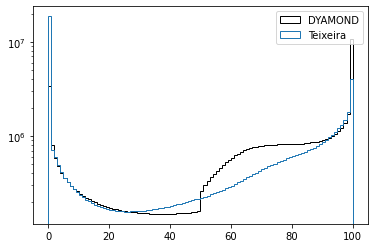

In [19]:
def predict(P,X):
    '''
        The objective function.
    '''
    D, K = P
    preds = np.minimum(np.maximum(func(X, D, K), 0), 100)

    return preds

plt.hist(flattened_output_valid,bins=100, histtype='step', color='k')
plt.hist(predict(res.x, flattened_input_valid),bins=100, histtype='step')

plt.yscale('log')
plt.legend(['DYAMOND', 'Teixeira'])
plt.savefig('results_Nelder-Mead_tuned_cl_area.pdf')

**Testing**

In [20]:
# From the other notebook
def teixeira_eval(input_data, output_data, loc, D, K):
    # What is the average error with this set of tuning parameters?
    clw = input_data[:, loc['clw']]
    cli = input_data[:, loc['cli']]
    ta = input_data[:, loc['ta']]
    r = input_data[:, loc['rh']]
    p = input_data[:, loc['pa']]

    # Clausius-Clapeyron assuming a constant latent heat of vaporization and the ideal gas law (Lohmann, eq. 2.60)
    e0 = 611.2
    Lv = 2.5*10**6
    Rv = 461.5
    T0 = 273.15
    e = e0*np.exp(Lv/Rv*(1/T0-1/ta))

    # q_s (Saturation specific humidity): The specific humidity of water vapor corresponding to the saturation mixing ratio
    # Assuming the water pressure to be much smaller than the atmospheric pressure (Lohmann, eq. 2.80)
    eps = 0.622
    qs = eps*e/p

    # Small threshold to avoid division by zero
    thr = 1e-9
    c = D*clw/(2*qs*(1-np.minimum(r, 1-thr))*K)*(np.sqrt(np.maximum(0, 1 + (4*qs*(1-np.minimum(r, 1-thr))*K)/(D*np.maximum(clw, thr)))) - 1)

    # c can exceed 1 very slightly
    c = np.minimum(c, 1)

    mse = np.mean((100*c - output_data)**2)
    var = np.var(output_data)
    r2 = 1-mse/var
    
    return mse, r2

D_opt = 0.01
K_opt = 0.0001002516165413534
mse_reg_1,_ = teixeira_eval(flattened_input_valid, flattened_output_valid, loc, D_opt, K_opt)

In [21]:
mse_orig_total = (mse_reg_0*len_reg_0 + mse_reg_1*len_reg_not_0)/len_data_output
r2_orig_total = 1 - mse_orig_total/var_data_output

print(mse_orig_total, r2_orig_total)

1373.4962001209562 0.2049738962046832
